# Imports

In [3]:
import numpy as np
import networkx as nx
import plotly.graph_objects as go 
import gudhi as gd
import matplotlib.pyplot as plt

# Functions

In [5]:
#Inputs: ts - a 2D np array of any shape. Probably a time series. 
# b - the number of bins in each dimension
#Output: bins - A dictionary of arrays that contains the boundaries of the bins in each dimension

def get_bins(ts,b):
    d,n = ts.shape
    bins = {}
    for i in range(d):
        top = max(ts[i,:])
        bot = min(ts[i,:])
        step = (top - bot)/b
        ibins = []
        for j in range(b+1):
            ibins.append(bot+j*step)
        bins[i] = ibins
    return bins

In [6]:
#Inputs: ts - time series
#bins - the partition of each dimension into its bins
#b - number of bins in each dimension

#Output: binseq - a 1D array the length of ts that lists which bin each entry in the time series is in

def bin_sequence(ts, bins, b):
    d,n = ts.shape
    binseq = np.zeros((n))
    for i in range(n):
        bin_n = 0
        for j in range(d):
            k = 1
            while k <= b:
                if ts[j,i] <= bins[j][k]:
                    bin_n += (k-1)*(b**j)
                    k = b + 1
                else: 
                    k = k + 1 
        binseq[i] = bin_n

    return binseq

In [7]:
#inputs: bin-seq - the bin sequence of the time series
#outputs: A - the adjacency matrix
# vertices - the list of vertices, enumerated as bin number

def adjacency(bin_seq, prob = False):
    vertices, counts = np.unique(bin_seq, return_counts=True)
    order = len(vertices)
    A = np.zeros((order,order))
    for i in range(len(bin_seq)-1):
        A[np.where(vertices == bin_seq[i]),np.where(vertices == bin_seq[i+1])] += 1
    if prob:
        A[:,i] = A[:,i]/np.sum(A[:,i])
    return A, vertices, counts

In [8]:
# inputs: A - the adjacency matrix
# vertices - the list of vertices, which are the bin numbers
# loops - whether or not to keep the self-loops in the graph, I am going to do something with this eventually when I include some sort of markovian random walk diffusion distance 
#Output: G - a networkx digraph

def digraph(A, vertices, counts, loops: bool):
    if loops == False:
        np.fill_diagonal(A,0)
        G = nx.DiGraph(A)
    elif loops == True:
        G = nx.DiGraph(A)
    for i in range(len(G.nodes)):
       G.nodes[i]['bin'] = vertices[i]
       G.nodes[i]['count'] = counts[i]

    return G

In [9]:
def bin_centers(bins, b):
    bin_cent = np.zeros((b**3,3))
    for k in range(b):
        for j in range(b):
            for i in range(b):
                bin_cent[k*b**2 + j*b + i,0] += np.mean(bins[0][i:i+2]) 
                bin_cent[k*b**2 + j*b + i,1] += np.mean(bins[1][j:j+2]) 
                bin_cent[k*b**2 + j*b + i,2] += np.mean(bins[2][k:k+2]) 

    return bin_cent

In [10]:
#Inputs: G - a networkx graph
# method - the way you want to measure distance on the graph
# Outputs: D - a distance matrix

def distance_matrix(G, method = 'unweighted_shortest_path'):
    if method == 'unweighted_shortest_path':
        lengths = dict(nx.all_pairs_shortest_path_length(G))
        D = np.full((len(lengths),len(lengths)),1000,dtype=float) # was -1 default
        for key in lengths:
            for item in lengths[key]:
                    D[key,item] = lengths[key][item]
    
    if method == 'probabilistic': #since I doubt we are doing this in this paper, I haven't checked exactly if this is right
        w = nx.get_edge_attributes(G,'weight')
        for key in w:
            w[key] = 1/w[key]
        nx.set_edge_attributes(G,w,name='weight')
        lengths = dict(nx.all_pairs_dijkstra_path_length(G))
        D = np.full((len(lengths),len(lengths)),1000,dtype=float) # was -1 default
        for key in lengths:
            for item in lengths[key]:
                if lengths[key][item] != 0:
                    D[key,item] = lengths[key][item]
                elif lengths[key][item] == 0:
                    D[key,item] = 0

    if method == 'weighted_shortest_path':
        lengths = dict(nx.all_pairs_dijkstra_path_length(G))
        D = np.full((len(lengths),len(lengths)),1000,dtype=float) # was -1 default
        for key in lengths:
            for item in lengths[key]:
                if lengths[key][item] != 0:
                    D[key,item] = lengths[key][item]
                elif lengths[key][item] == 0:
                    D[key,item] = 0

    return D

In [11]:
# This cell is copy-pasted from pyDowker
# by Niklas Hellmer and Jan Spalinski, but only the portion
# that's relevant to our project.
# See https://github.com/nihell/pyDowker


from gudhi import SimplexTree
import numpy as np

class DowkerComplex:
    """
    Class MNeighborComplex. Constructs Dowker's simplicial complex for a relation.
    Filtrations can be added using filtered relations, or total weight, or combining both into a bifiltration.
    """

    def __init__(self, rel_matrix, max_filtration=float('inf')) -> None:
        """_summary_
        Constructor for the filtered Dowker complex from the relations given by sublevels of the matrix rel_matrix.
        The vertices in the complex will correspond to the rows of the matrix.
        
        Parameters
        ----------
        rel_matrix (Sequence[Sequence[float]]): distance matrix (full square or lower triangular).
        max_filtration (float): specifies the maximal filtration value to be considered.      
        """
        self.rel_matrix = rel_matrix
        self.st = None
        
        
     

    def create_simplex_tree(self, 
                            max_dimension, 
                            filtration = 'None', 
                            m=1, 
                            level = 0, 
                            max_filtration = np.inf):
        """
            Creates a gudhi simplex tree storing a skeleton of the (filtered) simpicial complex.
            Uses recursive algorithm with nummpy arrays, fast for small datasets but worse runtime and memory complexity.


        Parameters
        ----------
        max_dimension : int
            Dimension of the skeleton to compute.
        filtration : str, optional
            valid values: "Sublevel", "TotalWeight", "None".
            "Sublevel" takes the filtration of relations by sublevels of the matrix.
            "Total weight" takes the filtration by sublevels of the negative total weight function.
            By default 'None'
        m : int, optional
            restriction to this superlevel of total weight (this is only used if filtration!="TotalWeight"); m=1 corresponds to the whole Dowker complex, by default 1
        level : int, optional
            restriction to this sublevel of the matrix as relation (this is only used if filtration!="Sublevel"), by default 0
        max_filtration : float, optional
            cutoff for the filtration (only used if filtration="Sublevel"), by default np.inf

        Returns
        -------
        gudhi.SimplexTree
            The simplex tree storing the (filtered) simplicial complex
        """
        
        self.st=SimplexTree()


        LAMBDA = self.rel_matrix
        num_points=len(LAMBDA)
        
        if filtration == "Sublevel":
            if LAMBDA.dtype != np.float64:
                raise TypeError("Only float arrays are allowed with sublevel filtration") 
            def append_upper_cofaces(sigma, r, witness_values):
                if r > max_filtration:
                    return
                self.st.insert(sigma,r)
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]

                        j_witness_values=LAMBDA[j,:]
                        common_witness_values = np.maximum(j_witness_values,witness_values)
                        new_r = np.partition(common_witness_values, m-1)[m-1]
                        append_upper_cofaces(tau, new_r, common_witness_values)

            for k in range(num_points-1,-1,-1):
                witness_values = LAMBDA[k,:]
                r_new = np.partition(witness_values, m-1)[m-1]
                append_upper_cofaces([k],r_new,witness_values)
            return self.st
        
        elif filtration == "TotalWeight":
            if LAMBDA.dtype != np.bool_:
                LAMBDA = LAMBDA <= level

            def append_upper_cofaces(sigma, witnesses):
                
                self.st.insert(sigma,-np.sum(witnesses))
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]
                        j_witnesses=LAMBDA[j,:]
                        common_witnesses = np.logical_and(j_witnesses,witnesses)
                        if np.sum(common_witnesses>0):
                            append_upper_cofaces(tau, common_witnesses)

            for k in range(num_points-1,-1,-1):
                witnesses = LAMBDA[k,:]
                append_upper_cofaces([k], witnesses)
            return self.st

        elif filtration == "None":
            if LAMBDA.dtype != np.bool_:
                LAMBDA = LAMBDA <= level

            def append_upper_cofaces(sigma, witnesses):
                if len(witnesses)<m:
                    return
                self.st.insert(sigma)
                if len(sigma)<=max_dimension:
                    for j in range(np.max(sigma)+1,num_points):
                        tau = sigma+[j]
                        j_witnesses=LAMBDA[j,:]
                        common_witnesses = np.logical_and(j_witnesses,witnesses)
                        if len(common_witnesses>0):
                            append_upper_cofaces(tau, common_witnesses)

            for k in range(num_points-1,-1,-1):
                witnesses = LAMBDA[k,:]
                append_upper_cofaces([k], witnesses)
            return self.st
        
        else:
            raise Exception("filtration parameter must be one of 'Sublevel', 'TotalWeight', 'None'")

In [12]:
def weight_graph(G, weights, smallest, biggest):


    edges = [e for e in G.edges]

    for e in edges:
        source = e[0]
        target = e[1]
        G[source][target]['weight'] = weights(smallest, biggest)

    return G

# For our experiments, we also need to generate synthetic cycle and figure eight graphs, with various directions and weights

## Unweighted Consistently Oriented Cycle

### Hexagon

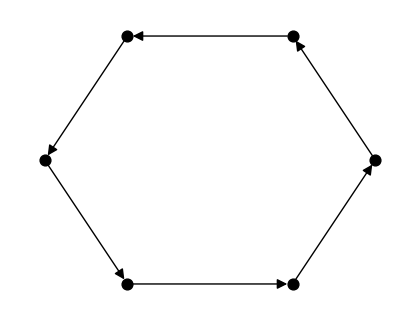

In [16]:
saveFig = 0; # if 1, save; if 0, don't save

# Create cycle graph using networkx
cycleG = nx.cycle_graph(6, create_using=nx.DiGraph)
# Draw cycle graph
pos = nx.circular_layout(cycleG)
plt.figure(figsize=(4, 3)) 
nx.draw(cycleG, pos, edge_color='black', node_size=60, node_color='black', arrowsize=15, width=1)

if saveFig == 1:
    plt.savefig("unwgt_consistcycle_hex.pdf")

In [17]:
# Compute persistence
Dcycle = distance_matrix(cycleG)
cyclecomplex = DowkerComplex(Dcycle).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmcycle = cyclecomplex.persistence()
dgmcycle

[(1, (1.0, 3.0)),
 (0, (0.0, inf)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

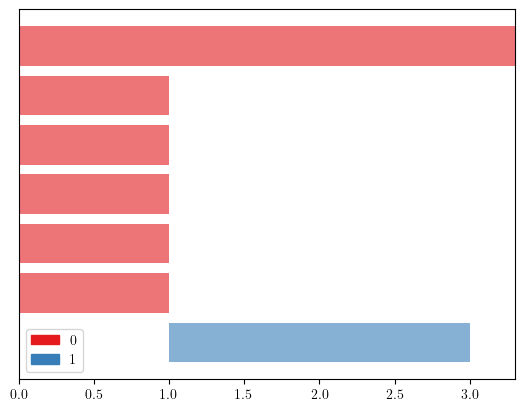

In [18]:
# Corresponding barcode for consistently oriented hexagon
gd.plot_persistence_barcode(dgmcycle)
plt.title('');
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
plt.gca().set_xlim(left=0)

if saveFig == 1:
    plt.savefig("unwgt_consistcycle_hex_barcode.pdf")

### Octagon

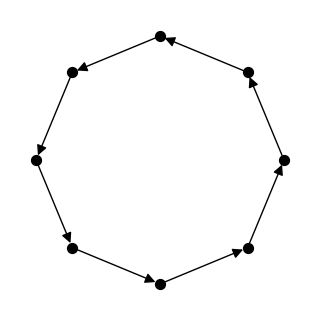

In [20]:
saveFig = 0; # if 1, save; if 0, don't save

# Create cycle graph using networkx
cycleG = nx.cycle_graph(8, create_using=nx.DiGraph)
# Draw cycle graph
pos = nx.circular_layout(cycleG)
plt.figure(figsize=(3, 3)) 
nx.draw(cycleG, pos, edge_color='black', node_size=50, node_color='black', arrowsize=15, width=1)

if saveFig == 1:
    plt.savefig("unwgt_consistcycle_oct.pdf")

In [21]:
# Compute persistence
Dcycle = distance_matrix(cycleG)
cyclecomplex = DowkerComplex(Dcycle).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmcycle = cyclecomplex.persistence()
dgmcycle

[(1, (1.0, 4.0)),
 (0, (0.0, inf)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

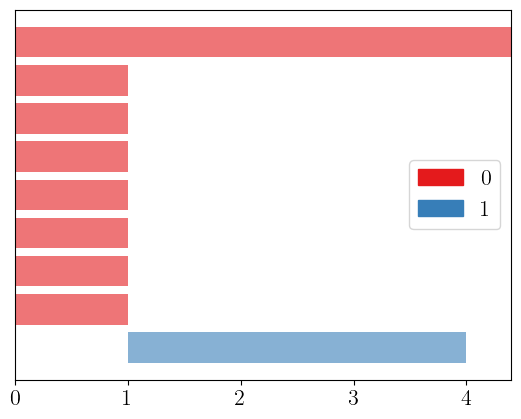

In [22]:
# Corresponding barcode for consistently oriented octagon
gd.plot_persistence_barcode(dgmcycle)
plt.title('');
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
plt.gca().set_xlim(left=0)

if saveFig == 1:
    plt.savefig("unwgt_consistcycle_oct_barcode.pdf")

## Weighted Consistently Oriented Cycle

### Hexagon

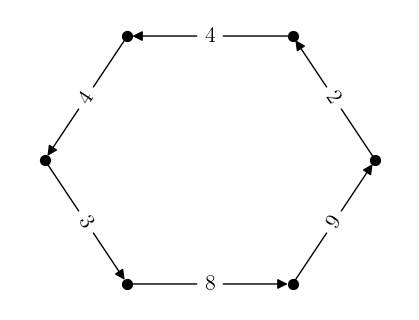

In [25]:
saveFig = 0; # if 1, save; if 0, don't save

# Create graph
cycleG = nx.cycle_graph(6, create_using=nx.DiGraph)
# Assign random weights
pos = nx.circular_layout(cycleG)
weightedcycleG = weight_graph(cycleG, np.random.randint, 1, 10)
edge_labels = nx.get_edge_attributes(weightedcycleG, 'weight')

plt.figure(figsize=(4, 3))
nx.draw(weightedcycleG, pos, node_color='black', node_size=50, edge_color='black', arrowsize=15, width=1)
nx.draw_networkx_edge_labels(weightedcycleG, pos, edge_labels=edge_labels, font_size=16, label_pos=0.5, font_color='black')

if saveFig == 1:
    plt.savefig("wgt_consistcycle_hex.pdf")


In [26]:
# Get distance matrix using weighted shortest path
Dcycleweighted = distance_matrix(weightedcycleG, 'weighted_shortest_path')

# Compute persistence
weightedcyclecomplex = DowkerComplex(Dcycleweighted).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmweightedcycle = weightedcyclecomplex.persistence()
dgmweightedcycle

[(1, (9.0, 15.0)),
 (0, (0.0, inf)),
 (0, (0.0, 8.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 2.0))]

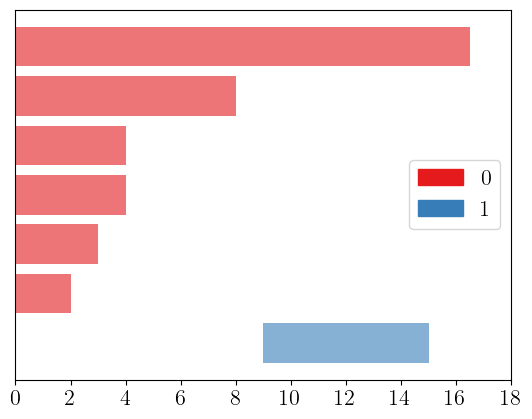

In [27]:
# Corresponding barcode for consistently oriented octagon
gd.plot_persistence_barcode(dgmweightedcycle)
plt.title('');
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)
ax = plt.gca()
xmin, xmax = ax.get_xlim()
plt.xticks(np.arange(0,xmax+2,2))
plt.gca().set_xlim(left=0)

if saveFig == 1:
    plt.savefig("wgt_consistcycle_hex_barcode.pdf")

### Octagon

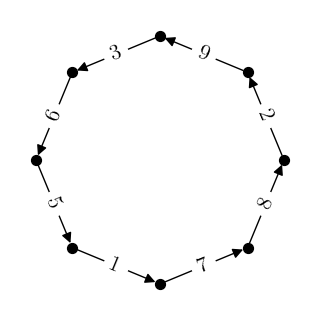

In [29]:
saveFig = 0; # if 1, save; if 0, don't save

# Create graph
cycleG = nx.cycle_graph(8, create_using=nx.DiGraph)
# Assign random weights
pos = nx.circular_layout(cycleG)
weightedcycleG = weight_graph(cycleG, np.random.randint, 1, 10)
edge_labels = nx.get_edge_attributes(weightedcycleG, 'weight')

plt.figure(figsize=(3, 3))
nx.draw(weightedcycleG, pos, node_color='black', node_size=50, edge_color='black', arrowsize=15, width=1)
nx.draw_networkx_edge_labels(weightedcycleG, pos, edge_labels=edge_labels, font_size=16, label_pos=0.5, font_color='black')

if saveFig == 1:
    plt.savefig("wgt_consistcycle_oct.pdf")


In [30]:
# Get distance matrix using weighted shortest path
Dcycleweighted = distance_matrix(weightedcycleG, 'weighted_shortest_path')

# Compute persistence
weightedcyclecomplex = DowkerComplex(Dcycleweighted).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmweightedcycle = weightedcyclecomplex.persistence()
dgmweightedcycle

[(1, (9.0, 21.0)),
 (0, (0.0, inf)),
 (0, (0.0, 8.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 1.0))]

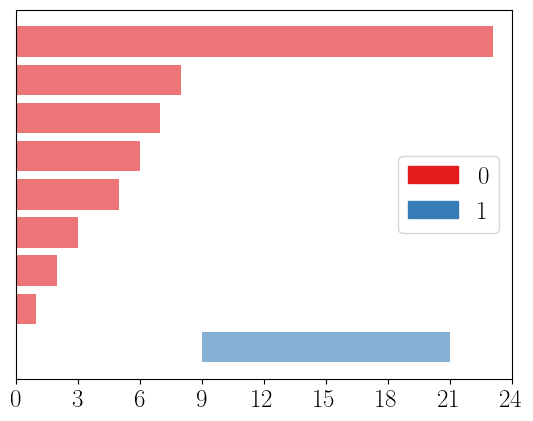

In [31]:
# Corresponding barcode for consistently oriented octagon
gd.plot_persistence_barcode(dgmweightedcycle)
plt.title('');
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)
# Get the x-axis limits
ax = plt.gca()
xmin, xmax = ax.get_xlim()
plt.xticks(np.arange(0,xmax+2,3))
plt.gca().set_xlim(left=0)

if saveFig == 1:
    plt.savefig("wgt_consistcycle_oct_barcode.pdf")

### Consistently-oriented cycle with one large edge

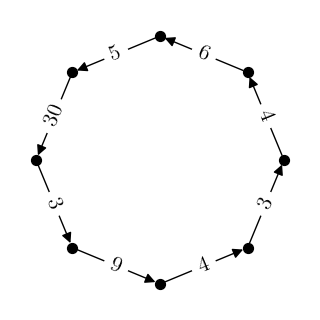

In [33]:
saveFig = 1; # if 1, save; if 0, don't save
# Create graph
cycleG = nx.cycle_graph(8, create_using=nx.DiGraph)

# Assign random weights
pos = nx.circular_layout(cycleG)
weightedcycleG = weight_graph(cycleG, np.random.randint, 1, 10)

# make one edge weight large
largeEdgewt = 30
weightedcycleG.remove_edge(3,4)
weightedcycleG.add_edge(3,4,weight=largeEdgewt)

edge_labels = nx.get_edge_attributes(weightedcycleG, 'weight')

plt.figure(figsize=(3, 3))
nx.draw(weightedcycleG, pos, node_color='black', node_size=50, edge_color='black', arrowsize=15, width=1)
nx.draw_networkx_edge_labels(weightedcycleG, pos, edge_labels=edge_labels, font_size=16, label_pos=0.5, font_color='black')

if saveFig == 1:
    plt.savefig("wgt_consistcycle_oct_largeEdge.pdf")

In [34]:
# Get distance matrix using weighted shortest path
Dcycleweighted = distance_matrix(weightedcycleG, 'weighted_shortest_path')

# Compute persistence
weightedcyclecomplex = DowkerComplex(Dcycleweighted).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmweightedcycle = weightedcyclecomplex.persistence()
dgmweightedcycle

[(1, (30.0, 33.0)),
 (0, (0.0, inf)),
 (0, (0.0, 9.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0))]

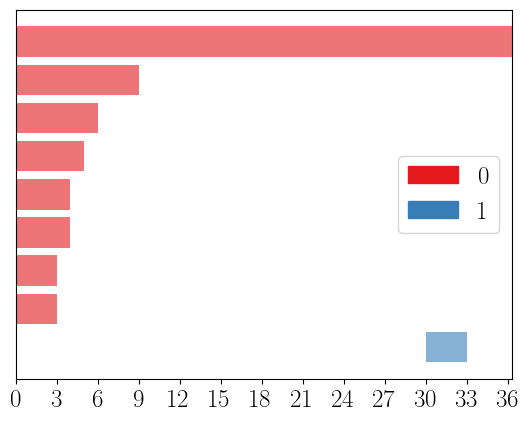

In [35]:
# Corresponding barcode for consistently oriented octagon
gd.plot_persistence_barcode(dgmweightedcycle)
plt.title('');
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)
# Get the x-axis limits
ax = plt.gca()
xmin, xmax = ax.get_xlim()
plt.xticks(np.arange(0,xmax+2,3))
plt.gca().set_xlim(left=0)

if saveFig == 1:
    plt.savefig("wgt_consistcycle_oct_largeEdge_barcode.pdf")

## Not Consistently Oriented, Unweigthed Cycle

### One source, one sink

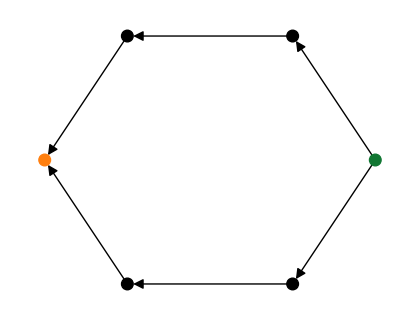

In [38]:
saveFig = 1 # if 1, save; if 0, don't save

# create cycle graph edges and vertices
notcycleG = nx.cycle_graph(6, create_using=nx.DiGraph)
# change orientation of desired edges
notcycleG.remove_edge(3,4)
notcycleG.remove_edge(4,5)
notcycleG.remove_edge(5,0)
notcycleG.add_edge(4,3)
notcycleG.add_edge(5,4)
notcycleG.add_edge(0,5)

# Draw cycle graph
pos = nx.circular_layout(notcycleG)
plt.figure(figsize=(4, 3)) 
# set node colors
nx.set_node_attributes(notcycleG, {0: '#117733', 3: '#ff7f0e'}, name='color')
for node in notcycleG.nodes:
    if 'color' not in notcycleG.nodes[node]:
        notcycleG.nodes[node]['color'] = 'black'
node_colors = [notcycleG.nodes[node]['color'] for node in notcycleG.nodes]
nx.draw(notcycleG, pos, edge_color='black', node_color=node_colors, node_size=70, arrowsize=15, width=1)

if saveFig == 1:
    plt.savefig("unwgt_notcycle_hex_1source1sink.pdf")

In [39]:
# Compute persistence
Dnotcycle = distance_matrix(notcycleG)
notcyclecomplex = DowkerComplex(Dnotcycle).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmnotcycle = notcyclecomplex.persistence()
dgmnotcycle

[(1, (1.0, 3.0)),
 (0, (0.0, inf)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

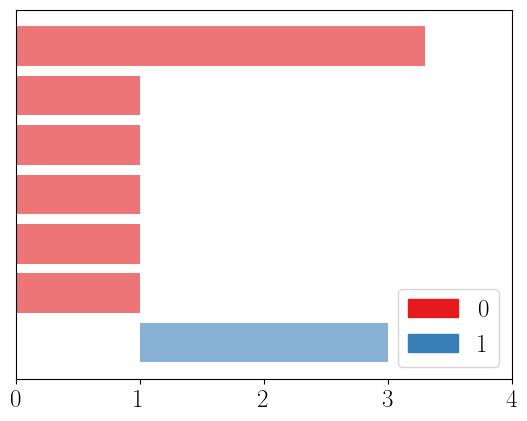

In [40]:
# Corresponding barcode for unweighted hexagon with one source and one sink
gd.plot_persistence_barcode(dgmnotcycle)
plt.title('');
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)
# Get the x-axis limits
ax = plt.gca()
xmin, xmax = ax.get_xlim()
plt.xticks(np.arange(0,xmax+1,1))
plt.gca().set_xlim(left=0)

if saveFig == 1:
    plt.savefig("unwgt_notcycle_hex_1source1sink_barcode.pdf")

## Not Consistently Oriented, Weighted Cycles

### One source, one sink

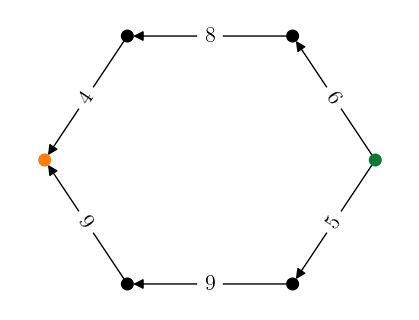

In [43]:
saveFig = 1 # if 1, save; if 0, don't save

# Example with 6 vertices, source at 0, sink at 3
numVerts = 6
notcycleG = nx.cycle_graph(numVerts, create_using=nx.DiGraph)
wtnotcycleG = weight_graph(notcycleG, np.random.randint, 1, 10)

wtnotcycleG.remove_edge(3,4)
wtnotcycleG.remove_edge(4,5)
wtnotcycleG.remove_edge(5,0)
# right now, generating new random weights, but could keep originally generated weights
wtnotcycleG.add_edge(4, 3, weight=np.random.randint(1,10))
wtnotcycleG.add_edge(5,4, weight=np.random.randint(1,10))
wtnotcycleG.add_edge(0,5, weight=np.random.randint(1,10))

# Draw cycle graph
pos = nx.circular_layout(notcycleG)
plt.figure(figsize=(4, 3)) 
edge_labels = nx.get_edge_attributes(wtnotcycleG, 'weight')
# set node colors
nx.set_node_attributes(notcycleG, {0: '#117733', 3: '#ff7f0e'}, name='color')
for node in notcycleG.nodes:
    if 'color' not in notcycleG.nodes[node]:
        notcycleG.nodes[node]['color'] = 'black'
node_colors = [notcycleG.nodes[node]['color'] for node in notcycleG.nodes]

nx.draw(wtnotcycleG, pos, edge_color='black', node_color=node_colors, node_size=70, arrowsize=15, width=1)
nx.draw_networkx_edge_labels(wtnotcycleG, pos, edge_labels=edge_labels, font_size=16, label_pos=0.5, font_color='black')

if saveFig == 1:
    plt.savefig("wgt_notcycle_hex_1source1sink.pdf")

In [44]:
# Get distance matrix using weighted shortest path
DwtnotcycleG = distance_matrix(wtnotcycleG, method='weighted_shortest_path')

# Compute persistence
wtnotcyclecomplex = DowkerComplex(DwtnotcycleG).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmwtnotcycle = wtnotcyclecomplex.persistence()
dgmwtnotcycle

[(1, (9.0, 18.0)),
 (0, (0.0, inf)),
 (0, (0.0, 9.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 4.0))]

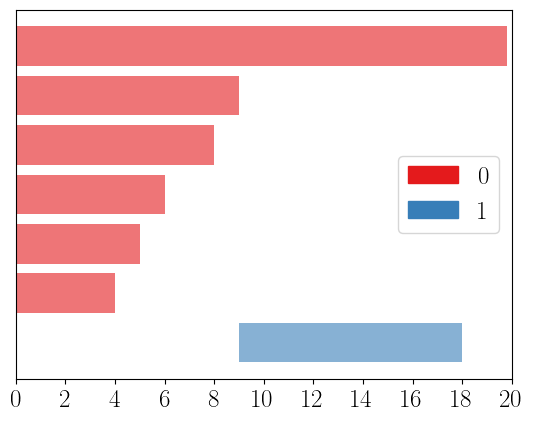

In [45]:
# Corresponding barcode for weighted hexagon with one source and one sink
gd.plot_persistence_barcode(dgmwtnotcycle)
plt.title('');
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)
ax = plt.gca()
xmin, xmax = ax.get_xlim()
plt.xticks(np.arange(0,xmax+2,2))
plt.gca().set_xlim(left=0)

if saveFig == 1:
    plt.savefig("wgt_notcycle_hex_1source1sink_barcode.pdf")

### Every other source/sink
<p>Even number of vertices; every other vertex a source</p>
<p>Should have one cycle persist indefinitely.</p>

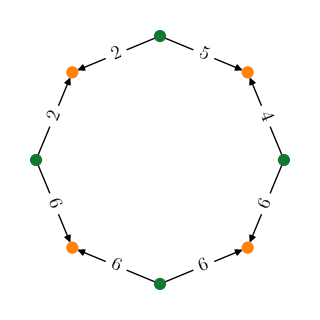

In [47]:
# Example with numVerts vertices, every other is source/sink
saveFig = 0 # if 1, save; if 0, don't save
numVerts = 8 # make even for alternating
G = nx.cycle_graph(numVerts, create_using=nx.DiGraph)
G = weight_graph(G, np.random.randint, 1, 10)

weightDict = nx.get_edge_attributes(G, 'weight')

for k in range(1, numVerts+1, 2):
    node1 = k
    node2 = (k+1)%numVerts
    
    current_weight = weightDict[(node1, node2)]
    
    G.remove_edge(node1, node2)
    G.add_edge(node2, node1, weight=current_weight)

# Draw cycle graph
pos = nx.circular_layout(G)
plt.figure(figsize=(3, 3)) 
edge_labels = nx.get_edge_attributes(G, 'weight')
# set node colors
for node in G.nodes:
    if 'color' not in G.nodes[node]:
        if (node % 2) == 0:
            G.nodes[node]['color'] = '#117733'
        else:
            G.nodes[node]['color'] = '#ff7f0e'
node_colors = [G.nodes[node]['color'] for node in G.nodes]

nx.draw(G, pos, edge_color='black', node_color=node_colors, node_size=60, arrowsize=10, width=1)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=14, label_pos=0.5, font_color='black')

if saveFig == 1:
    plt.savefig("wgt_oct_everyOtherSourceSink.pdf")

In [48]:
# Compute persistence
DwtnotcycleG = distance_matrix(G, method='weighted_shortest_path')
wtnotcyclecomplex = DowkerComplex(DwtnotcycleG).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmwtnotcycle = wtnotcyclecomplex.persistence()
dgmwtnotcycle # One cycle persists indefinitely!

[(1, (6.0, 1000.0)),
 (0, (0.0, inf)),
 (0, (0.0, 6.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0))]

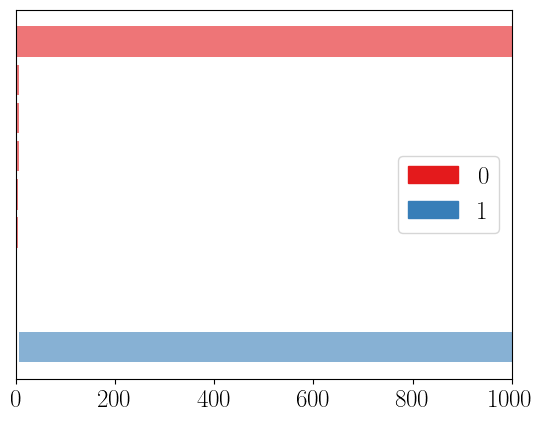

In [49]:
# Corresponding barcode for octogon with alternating source/sink
gd.plot_persistence_barcode(dgmwtnotcycle)
plt.title('');
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)
ax = plt.gca()
xmin, xmax = ax.get_xlim()
#plt.xticks(np.arange(0,xmax+2,2))
plt.gca().set_xlim(left=0, right=1000)


if saveFig == 1:
    plt.savefig("wgt_oct_everyOtherSourceSink_barcode.pdf")

### Two opposing sources

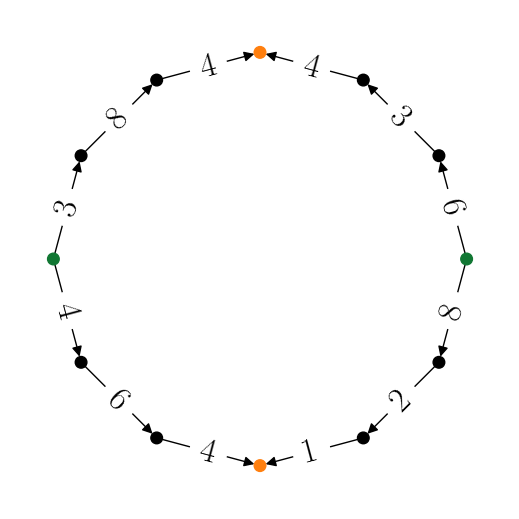

In [51]:
# Example with 12 vertices, sources at 0 and 6, sinks at 3 and 9
saveFig = 1 # if 1, save; if 0, don't save

numVerts = 12
source1 = 0
sink1 = 3
source2 = 6
sink2 = 9
Gtwosource = nx.cycle_graph(numVerts, create_using=nx.DiGraph)
Gtwosource = weight_graph(Gtwosource, np.random.randint, 1, 10)

weightDict = nx.get_edge_attributes(Gtwosource, 'weight')

# Swap direction between sink1 and source2
for k in range(sink1, source2, 1):
    node1 = k
    node2 = (k+1)%numVerts
    
    current_weight = weightDict[(node1, node2)] # keeping current weights; could generate new random weights
    
    Gtwosource.remove_edge(node1, node2)
    Gtwosource.add_edge(node2, node1, weight=current_weight)

# Swap direction between sink2 and source1
for k in range(sink2, numVerts, 1):
    node1 = k
    node2 = (k+1)%numVerts
    
    current_weight = weightDict[(node1, node2)] # keeping current weights; could generate new random weights
    
    Gtwosource.remove_edge(node1, node2)
    Gtwosource.add_edge(node2, node1, weight=current_weight)


# Draw cycle graph
pos = nx.circular_layout(Gtwosource)
plt.figure(figsize=(5, 5)) 
edge_labels = nx.get_edge_attributes(Gtwosource, 'weight')
# set node colors
nx.set_node_attributes(Gtwosource, {source1: '#117733', source2: '#117733', sink1: '#ff7f0e', sink2: '#ff7f0e'}, name='color')
for node in Gtwosource.nodes:
    if 'color' not in Gtwosource.nodes[node]:
        Gtwosource.nodes[node]['color'] = 'black'
node_colors = [Gtwosource.nodes[node]['color'] for node in Gtwosource.nodes]

nx.draw(Gtwosource, pos, edge_color='black', node_color=node_colors, node_size=70, arrowsize=15, width=1)
nx.draw_networkx_edge_labels(Gtwosource, pos, edge_labels=edge_labels, font_size=25, label_pos=0.5, font_color='black')

if saveFig == 1:
    figFileName = "wgt_" + str(numVerts) + "_twoSources.pdf";
    plt.savefig(figFileName)

In [52]:
Dtwosource = distance_matrix(Gtwosource, method='weighted_shortest_path')
complextwosource = DowkerComplex(Dtwosource).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmtwosource = complextwosource.persistence()
dgmtwosource

[(1, (8.0, 15.0)),
 (0, (0.0, inf)),
 (0, (0.0, 8.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 1.0))]

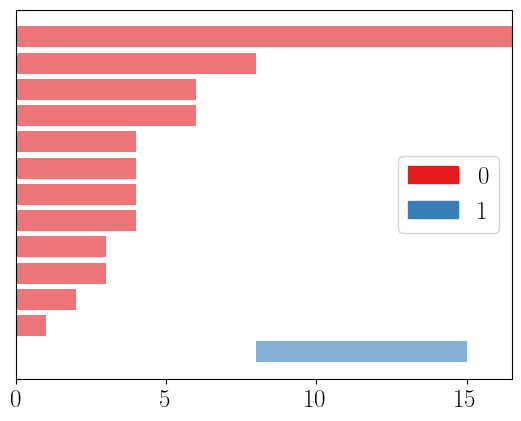

In [53]:
# Corresponding barcode for weighted 22 vertices with two sources
gd.plot_persistence_barcode(dgmtwosource)
plt.title('');
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)
ax = plt.gca()
xmin, xmax = ax.get_xlim()
#plt.xticks(np.arange(0,xmax+2,2))
plt.gca().set_xlim(left=0)


if saveFig == 1:
    figFileName = "wgt_" + str(numVerts) + "_twoSources_barcode.pdf";
    plt.savefig(figFileName)

### One source and one sink source, one edge with large weight (HASN'T BEEN FORMATTED)

In [55]:
# Example with 12 vertices, sink at 0, source at 6, large weight on edge (5,4)
numVerts = 12
notcycleG = nx.cycle_graph(numVerts, create_using=nx.DiGraph)
Glrgwt = weight_graph(notcycleG, np.random.randint, 1, 10)

source = 6
sink = 0

weightDict = nx.get_edge_attributes(Glrgwt, 'weight')

# Swap direction between sink1 and source2
for k in range(sink, source, 1):
    node1 = k
    node2 = (k+1)%numVerts
    
    current_weight = weightDict[(node1, node2)] # keeping current weights; could generate new random weights
    
    Glrgwt.remove_edge(node1, node2)
    Glrgwt.add_edge(node2, node1, weight=current_weight)

# Replace one edge with large weight
Glrgwt.remove_edge(5,4)
Glrgwt.add_edge(5,4,weight=200)

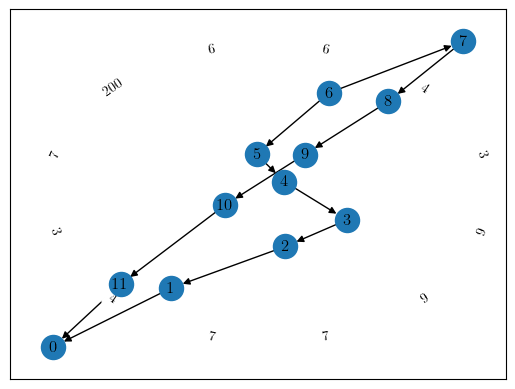

In [56]:
nx.draw_networkx(Glrgwt)
pos=nx.circular_layout(Glrgwt) # was nx.spring_layout
labels = nx.get_edge_attributes(Glrgwt,'weight')
nx.draw_networkx_edge_labels(Glrgwt,pos,edge_labels=labels)
plt.show()

In [57]:
DwtnotcycleG = distance_matrix(wtnotcycleG, method='weighted_shortest_path')

In [58]:
DwtnotcycleG

array([[   0.,    6.,   14.,   18.,   14.,    5.],
       [1000.,    0.,    8.,   12., 1000., 1000.],
       [1000., 1000.,    0.,    4., 1000., 1000.],
       [1000., 1000., 1000.,    0., 1000., 1000.],
       [1000., 1000., 1000.,    9.,    0., 1000.],
       [1000., 1000., 1000.,   18.,    9.,    0.]])

In [59]:
wtnotcyclecomplex = DowkerComplex(DwtnotcycleG).create_simplex_tree(filtration='Sublevel', max_dimension=2)

In [60]:
dgmwtnotcycle = wtnotcyclecomplex.persistence()

In [61]:
dgmwtnotcycle

[(1, (9.0, 18.0)),
 (0, (0.0, inf)),
 (0, (0.0, 9.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 4.0))]

# Wedges

In [117]:
# Inputs: G1 - a networkx graph
#        G2 - a networkx graph
# Outputs: G - a wedge sum of G1 and G2 where lowest node label of G2 is highest node label of G1 
def wedge_graphs(G1, G2):
    n1 = G1.number_of_nodes()
    n2 = G2.number_of_nodes()

    relabels = {i: i + n1 for i in range(n2-1)} # distinct labels for G2's nodes
    relabels[n2-1] = n1-1 # G2's first node is G1's last node (like a figure 8)
    G2 = nx.relabel_nodes(G2, relabels)
    G = nx.compose(G1, G2)
    return G

# Inputs: n1 - number of nodes in first cycle
#         n2 - number of nodes in second cycle
# Outputs: G - a wedge sum of two cycles, like a figure 8
def wedge_cycles(n1, n2):
    G1 = nx.cycle_graph(n1, create_using=nx.DiGraph)
    G2 = nx.cycle_graph(n2, create_using=nx.DiGraph)
    return wedge_graphs(G1, G2)

def figure_8_dgm(n1, n2, weighted = False):
    G = wedge_cycles(n1, n2)
    if weighted:
        weightedG = weight_graph(G, np.random.randint, 1, 10)
        D = distance_matrix(weightedG, 'weighted_shortest_path')
    else:
        D = distance_matrix(G, 'unweighted_shortest_path')
    complex = DowkerComplex(D).create_simplex_tree(filtration='Sublevel', max_dimension=2)
    dgms = complex.persistence()
    return dgms, G

In [119]:
dgms, fig8 = figure_8_dgm(5, 12, weighted=True)

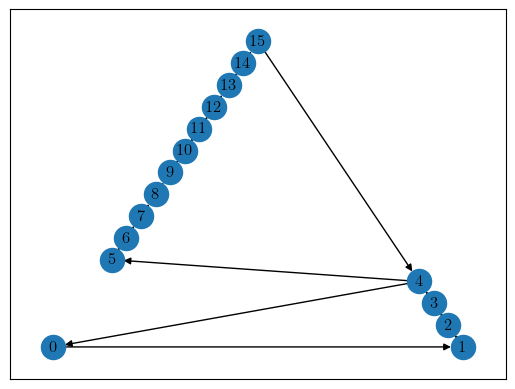

In [121]:
nx.draw_networkx(fig8, pos=nx.planar_layout(fig8))
# guarantee no crossings, but the proportions might be odd looking 

In [123]:
dgms

[(1, (9.0, 28.0)),
 (1, (9.0, 17.0)),
 (0, (0.0, inf)),
 (0, (0.0, 7.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

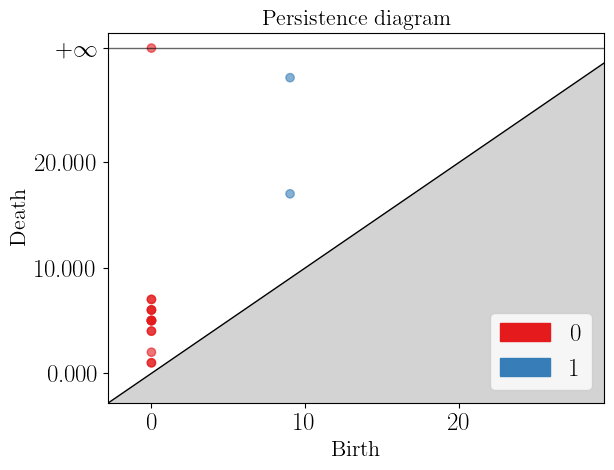

In [125]:
gd.plot_persistence_diagram(dgms)
plt.show()

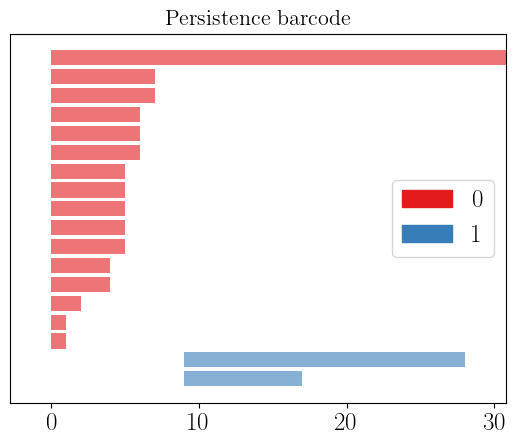

In [127]:
gd.plot_persistence_barcode(dgms)
plt.show()

In [131]:
def wedge_barcode_differences(G1, G2, weighted = False):
    # claim that the dim 1 barcode of wedge is the union of the two barcodes

    G = wedge_graphs(G1, G2)
    graphs = [G1, G2, G]

    # get the dimension 1 persistence diagrams for each graph
    all_dgms = []
    for graph in graphs:
        if weighted:
            D = distance_matrix(graph, 'weighted_shortest_path')
        else:
            D = distance_matrix(graph, 'unweighted_shortest_path')
        complex = DowkerComplex(D).create_simplex_tree(filtration='Sublevel', max_dimension=2)
        dgms = complex.persistence()
        dgm_dim1 = [dgm[1] for dgm in dgms if dgm[0] == 1]
        all_dgms.append(dgm_dim1)

    dgm_union = set(all_dgms[0] + all_dgms[1]) # union of the two individual barcodes
    wedged_dgm = set(all_dgms[2]) # barcode of the wedge sum
    if dgm_union != wedged_dgm:
        print("Dimension 1 barcode of wedge sum does NOT match the union of the individual barcodes.")
    else:
        print("Dimension 1 barcode of wedge sum DOES match the union of the individual barcodes.")
        
    print("Diagram of G1:", all_dgms[0])
    print("Diagram of G2:", all_dgms[1])
    print("Diagram of wedge sum:", all_dgms[2])
    return all_dgms



In [133]:
n1 = 5
n2 = 12
G1 = nx.cycle_graph(n1, create_using=nx.DiGraph)
G2 = nx.cycle_graph(n2, create_using=nx.DiGraph)

dgms_dim1  = wedge_barcode_differences(G1, G2, weighted=True)

Dimension 1 barcode of wedge sum DOES match the union of the individual barcodes.
Diagram of G1: [(1.0, 3.0)]
Diagram of G2: [(1.0, 6.0)]
Diagram of wedge sum: [(1.0, 6.0), (1.0, 3.0)]


In [135]:
weightedG1 = weight_graph(G1, np.random.randint, 1, 10)
weightedG2 = weight_graph(G2, np.random.randint, 1, 10)
dgms_dim1_weighted = wedge_barcode_differences(weightedG1, weightedG2, weighted=True)

Dimension 1 barcode of wedge sum DOES match the union of the individual barcodes.
Diagram of G1: [(8.0, 14.0)]
Diagram of G2: [(9.0, 37.0)]
Diagram of wedge sum: [(9.0, 37.0), (8.0, 14.0)]


## Cactus

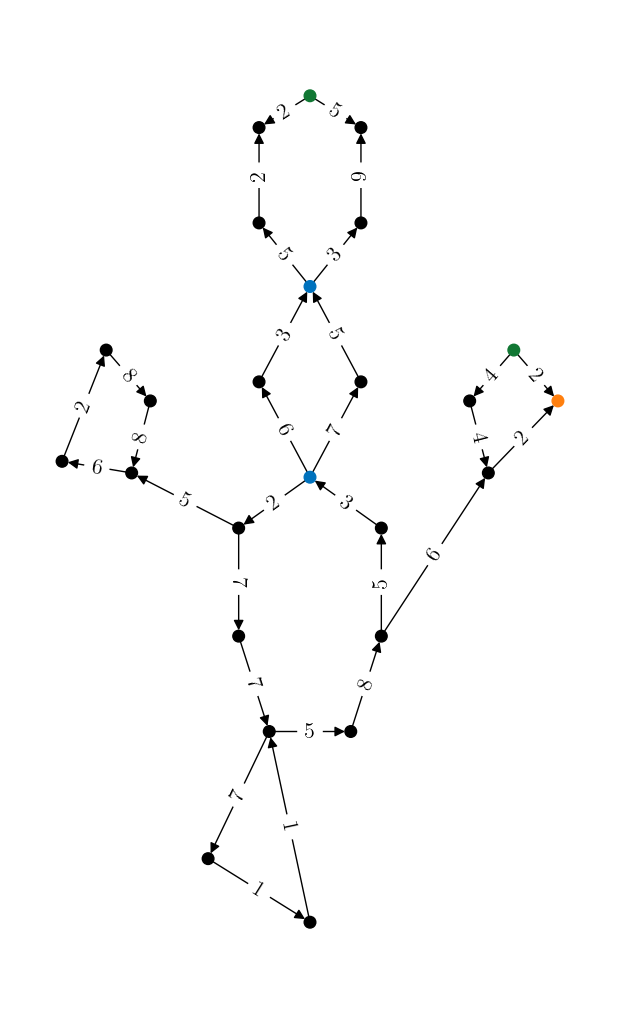

<Figure size 640x480 with 0 Axes>

In [394]:
saveFig = 1 # if 1, save; if 0, don't save

nodelist=np.arange(0,25)

sources = [0, 8, 20]

numVerts = len(nodelist)
G = nx.cycle_graph(numVerts, create_using=nx.DiGraph)
#Gwt = weight_graph(G, np.random.randint, 1, 10)

# remove all edges
G.remove_edges_from(list(G.edges()))

#G.add_nodes_from(nodelist)
G.add_edges_from([(i, i+1) for i in nodelist[0:6]])
G.add_edges_from([(i, i+1) for i in nodelist[10:13]])
G.add_edges_from([(i, i+1) for i in nodelist[14:17]])
edgelist = ((6,0), (0,7), (7,8), (0,9), (9,8), (10,13), (17,14),
           (8,18), (18,19), (20,19), (20,21), (8,22), (22,21),
           (1,16), (5,12),(3,23),(23,24),(24,3))
[G.add_edges_from([k]) for k in edgelist]

Gwt = weight_graph(G, np.random.randint, 1, 10)

pos_list = ((0, 1),(-0.7,0.2),(-0.7,-1.5),(-0.4,-3),
            (0.4,-3),(0.7,-1.5),(0.7,0.2),(0.5,2.5),
            (0,4),(-0.5,2.5), (2, 3), (1.567,2.2), (1.75, 1.067),
            (2.433,2.2), (-2,3),(-1.567,2.2),(-1.75,1.067),
            (-2.433,1.25),(0.5,5),(0.5,6.5),(0,7),(-0.5,6.5),(-0.5,5),
            (-1,-5),(0,-6))

pos = {k: p for k, p in zip(nodelist, pos_list)}

edge_lab = nx.get_edge_attributes(Gwt, 'weight')
# set node colors
myblue = '#0072BD' # node is source and sink
mygreen = '#117733'
myorange = '#ff7f0e'

nx.set_node_attributes(Gwt, {0: myblue, 8: myblue, 10: mygreen, 13: myorange, 20: mygreen}, name='color')
for node in Gwt.nodes:
    if 'color' not in Gwt.nodes[node]:
        Gwt.nodes[node]['color'] = 'black'
node_colors = [Gwt.nodes[node]['color'] for node in Gwt.nodes]


plt.figure(figsize=(6, 10)) 
nx.draw(Gwt, pos, edge_color='black', node_color=node_colors, node_size=70, arrowsize=15, width=1)
nx.draw_networkx_edge_labels(Gwt, pos, edge_labels=edge_labels, font_size=16, label_pos=0.5, font_color='black')

if saveFig == 1:
    plt.savefig("wgt_cactus.pdf")

In [396]:
# Get distance matrix using weighted shortest path
DwtG = distance_matrix(Gwt, method='weighted_shortest_path')

# Compute persistence
cactuscomplex = DowkerComplex(DwtG).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgmwtcactus = cactuscomplex.persistence()
dgmwtcactus

[(1, (9.0, 15.0)),
 (1, (8.0, 14.0)),
 (1, (9.0, 12.0)),
 (1, (8.0, 10.0)),
 (0, (0.0, inf)),
 (0, (0.0, 9.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 8.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 7.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 1.0))]

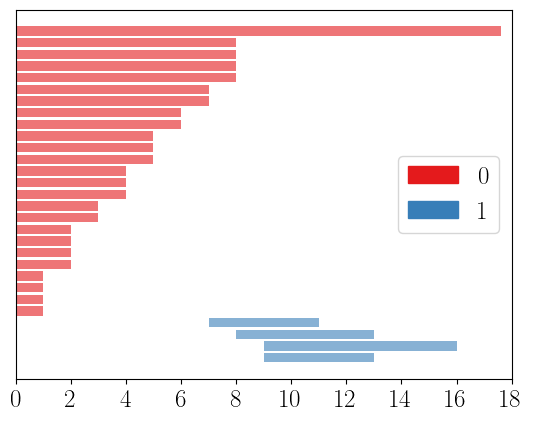

In [390]:
# Corresponding barcode for weighted hexagon with one source and one sink
gd.plot_persistence_barcode(dgmwtcactus)
plt.title('');
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)
ax = plt.gca()
xmin, xmax = ax.get_xlim()
plt.xticks(np.arange(0,xmax+2,2))
plt.gca().set_xlim(left=0)

if saveFig == 1:
    plt.savefig("wgt_cactus_barcode.pdf")

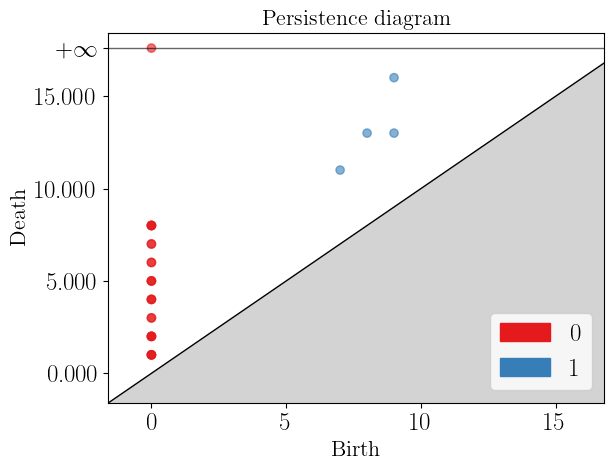

In [392]:
gd.plot_persistence_diagram(dgmwtcactus)
plt.show()